In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# prompt: read all the csv files "D:\OneDrive - The Pennsylvania State University\Research DATA\Dr. Habib & Dr. Reza Data\Energy Price Market Data\Day Ahead Price Data_Processed\USA\NYISO" and merge into a one dataframe df

folder_path = r"D:\OneDrive - The Pennsylvania State University\Research DATA\Dr. Habib & Dr. Reza Data\Energy Price Market Data\Day Ahead Price Data_Processed\USA\NYISO"

all_nyiso_data = pd.DataFrame()

for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            try:
                df_temp = pd.read_csv(file_path)
                all_nyiso_data = pd.concat([all_nyiso_data, df_temp], ignore_index=True)
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")

df = all_nyiso_data.copy() # Assign the concatenated dataframe to df
print(df)

               Timestamp  CAPITL  CENTRL  DUNWOD  GENESE    H Q  HUD VL  \
0       01/01/2000 00:00   42.88   39.49   43.70   38.98  39.98   42.92   
1       01/01/2000 01:00   41.55   38.26   42.34   37.77  38.74   41.58   
2       01/01/2000 02:00   40.98   37.74   41.76   37.25  38.20   41.01   
3       01/01/2000 03:00   36.59   33.69   37.28   33.26  34.11   36.62   
4       01/01/2000 04:00   42.88   39.49   43.70   38.98  39.98   42.92   
...                  ...     ...     ...     ...     ...    ...     ...   
222857  06/04/2025 19:00   59.72   57.66   60.76   56.99  55.75   60.25   
222858  06/04/2025 20:00   58.57   57.73   59.75   57.56  55.74   59.41   
222859  06/04/2025 21:00   50.16   48.17   49.49   47.88  47.53   49.30   
222860  06/04/2025 22:00   41.36   40.40   42.16   40.00  39.93   41.84   
222861  06/04/2025 23:00   36.23   35.46   37.07   35.39  34.70   36.89   

        LONGIL  MHK VL  MILLWD  N.Y.C.  NORTH    NPX    O H    PJM   WEST  
0        43.72   41.15 

In [3]:
df.head()

,Timestamp,CAPITL,CENTRL,DUNWOD,GENESE,H Q,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,NPX,O H,PJM,WEST
0,01/01/2000 00:00,42.88,39.49,43.70,38.98,39.98,42.92,43.72,41.15,43.08,44.52,40.03,42.04,37.68,38.52,37.49
1,01/01/2000 01:00,41.55,38.26,42.34,37.77,38.74,41.58,42.35,39.86,41.74,43.40,38.79,40.73,36.51,37.32,36.32
2,01/01/2000 02:00,40.98,37.74,41.76,37.25,38.20,41.01,40.88,39.32,41.17,43.18,38.25,40.17,36.01,36.81,35.82
3,01/01/2000 03:00,36.59,33.69,37.28,33.26,34.11,36.62,37.90,35.10,36.75,40.83,34.15,35.86,32.15,32.86,31.98
4,01/01/2000 04:00,42.88,39.49,43.70,38.98,39.98,42.92,41.00,41.15,43.08,44.52,40.03,42.04,37.68,38.52,37.49


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222862 entries, 0 to 222861
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Timestamp  222862 non-null  object 
 1   CAPITL     222862 non-null  float64
 2   CENTRL     222862 non-null  float64
 3   DUNWOD     222862 non-null  float64
 4   GENESE     222862 non-null  float64
 5   H Q        222862 non-null  float64
 6   HUD VL     222862 non-null  float64
 7   LONGIL     222862 non-null  float64
 8   MHK VL     222862 non-null  float64
 9   MILLWD     222862 non-null  float64
 10  N.Y.C.     222862 non-null  float64
 11  NORTH      222862 non-null  float64
 12  NPX        222862 non-null  float64
 13  O H        222862 non-null  float64
 14  PJM        222862 non-null  float64
 15  WEST       222862 non-null  float64
dtypes: float64(15), object(1)
memory usage: 27.2+ MB


In [5]:
# Data Preprocessing
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['CAPITL'].values.reshape(-1,1))


# Creating a data structure with 60 timesteps and 1 output
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Splitting the data into training and testing sets based on the year
train_df = df[df.index < "2023-01-01"]
test_df = df[df.index >= "2023-01-01"]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Train years:", train_df.index.year.unique())
print("Test years:", test_df.index.year.unique())



train_scaled = scaler.transform(train_df['CAPITL'].values.reshape(-1,1))
test_scaled = scaler.transform(test_df['CAPITL'].values.reshape(-1,1))

Train shape: (201601, 15)
Test shape: (21261, 15)
Train years: Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype='int32', name='Timestamp')
Test years: Index([2023, 2024, 2025], dtype='int32', name='Timestamp')


D:\Users\smrez\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 585s 90ms/step - loss: 3.9236e-04 - val_loss: 4.6487e-05
Epoch 2/2
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 645s 102ms/step - loss: 6.7780e-05 - val_loss: 5.9325e-05
663/663 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step


C:\Users\smrez\AppData\Local\Temp\ipykernel_17388\105118942.py:37: RuntimeWarning: divide by zero encountered in divide
  mape_rnn = np.mean(np.abs((test_actual_rnn - predicted_prices_rnn) / test_actual_rnn)) * 100


MAPE: inf%, R² Value: 0.9423674540198373
RNN MAE: 4.6458416066692205, RMSE: 8.852251036237414


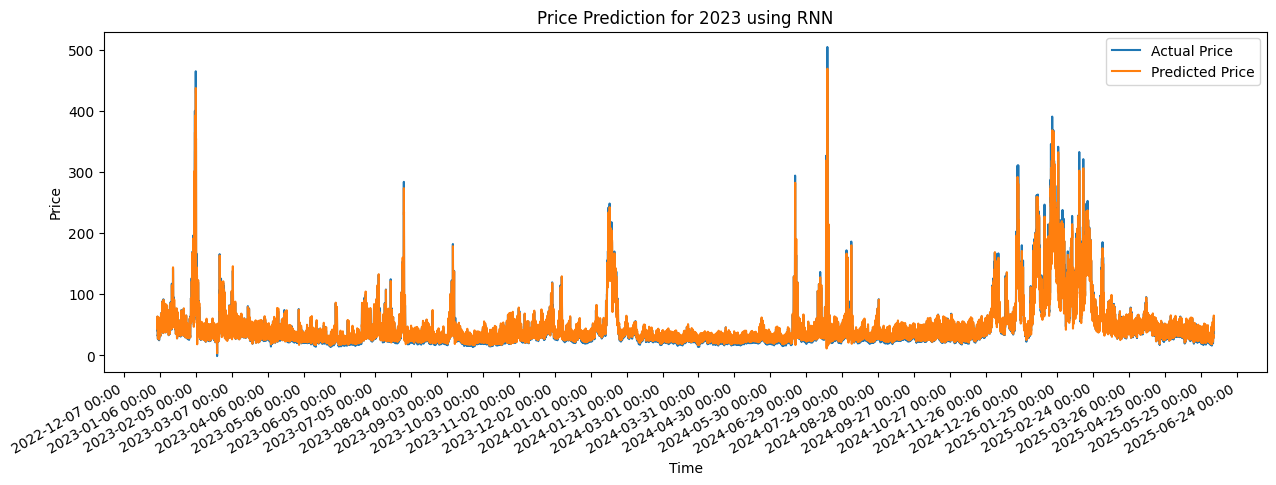

In [6]:


X_train, y_train, X_test, y_test = [], [], [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i-60:i, 0])
    y_test.append(test_scaled[i, 0])
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Reshaping for RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# RNN Network
model_rnn = Sequential([
    SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    SimpleRNN(units=50),
    Dropout(0.2),
    Dense(units=1)
])
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_rnn = model_rnn.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predictions
predicted_prices_rnn = model_rnn.predict(X_test)
predicted_prices_rnn = scaler.inverse_transform(predicted_prices_rnn)

# Evaluation
test_actual_rnn = scaler.inverse_transform(y_test.reshape(-1, 1))
mse_rnn = mean_squared_error(test_actual_rnn, predicted_prices_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(test_actual_rnn, predicted_prices_rnn)
mape_rnn = np.mean(np.abs((test_actual_rnn - predicted_prices_rnn) / test_actual_rnn)) * 100

# Calculate R² value
r2_rnn = r2_score(test_actual_rnn, predicted_prices_rnn)

print(f"MAPE: {mape_rnn}%, R² Value: {r2_rnn}")
print(f"RNN MAE: {mae_rnn}, RMSE: {rmse_rnn}")

# Truncate the test_actual_rnn array to match the length of predicted_prices_rnn
test_actual_truncated_rnn = test_actual_rnn[-len(predicted_prices_rnn):]

# Adjust the test_df index to match the length of the predictions
test_df_index_truncated_rnn = test_df.index[-len(predicted_prices_rnn):]

# Visualization
plt.figure(figsize=(15, 5))
plt.plot(test_df_index_truncated_rnn, test_actual_truncated_rnn, label='Actual Price')
plt.plot(test_df_index_truncated_rnn, predicted_prices_rnn, label='Predicted Price')
plt.title('Price Prediction for 2023 using RNN')
plt.xlabel('Time')
plt.ylabel('Price')

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust interval as needed
plt.gcf().autofmt_xdate()  # Improve date label formatting

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
# Predictions
predicted_prices = model_rnn.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate residuals
residuals = test_actual - predicted_prices

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=25, alpha=0.75, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(x=test_actual, y=residuals, alpha=0.75)
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs. Actual Prices')
plt.show()
